In [1]:
import os
import re
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt
import numba
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

# MICE flow:
* We load the data on which we want to compute the mutual information
* We create a neural network that can compute that loss
* We train the network and estimate the mutual information using some kind of averaging
* We can then transfer the same network for different temperatures and sub shapes

# Loading the data:
Here we will use the 2d ising data we have as an example
Our data was save as sequence of bits where each bit is a spin, 1 for up and 0 for down, we therefore do some manipulation to the file, using numba to fasten the computation

In [2]:
import numba

@numba.jit(nopython=True)
def bits_array_to_bytes_array(bits_array):
    bytes_array_shape = (bits_array.shape[0], bits_array.shape[1], bits_array.shape[2]*8)
    bytes_array = np.zeros(bytes_array_shape, dtype=np.uint8)
    for i in range(bits_array.shape[0]):
        for j in range(bits_array.shape[1]):
            for k in range(bits_array.shape[2]):
                for bit_idx in range(8):
                    byte = bits_array[i,j,k]
                    bytes_array[i,j,k*8 + bit_idx] = np.uint8(byte & (np.uint8(1) << bit_idx) != 0)
    return bytes_array

def file_to_ising_array(filename):
    size = 64
    frames = 10000
    all_spins = np.fromfile(filename, dtype=np.uint8)
    return bits_array_to_bytes_array(np.reshape(all_spins, (frames, size, int(size/8))))

def get_ising_matrices(T, directory):
    for filename in sorted(os.listdir(directory)):
        sim_T = float(re.findall("\d+\.\d+", filename)[0])
        if sim_T == T:
            ising_matrices = file_to_ising_array(os.path.join(directory,filename))
            return ising_matrices

directory = r'ising_2d'
T = 4
ising_matrices = get_ising_matrices(T, directory)


# Data preprocessing
Before using the data, we want to make sure it is:
* Centered around 0 
* floats
* We can also expand our dataset by adding mirrors of our data

In [3]:
ising_matrices = np.array(ising_matrices, dtype=np.float32)
ising_matrices -= 0.5
ising_matrices *= 2
ising_matrices = np.concatenate([ising_matrices, np.flip(ising_matrices, axis=1), np.flip(ising_matrices, axis=2)])

In [4]:

ising_matrices.shape

(30000, 64, 64)

We would now split the data in to train and test, and get all the subsystems of size (16,16) of our simulation

In [5]:
# This is not an efficient implementation, but it is good enough
def get_all_sub_matrices(matrices, sub_shape, step=1):
    if len(matrices.shape) != 3:
        raise Exception('Works only for 3d right now')
    if(len(sub_shape) != 2):
        raise Exception('Works only for 3d right now')
        
    all_subs = []
    max_i = matrices.shape[1] - sub_shape[0] + 1
    max_j = matrices.shape[2] - sub_shape[1] + 1
    for i in range(0, max_i, step):
        for j in range(0, max_j, step):
            sub_matrix = matrices[:, i:i+sub_shape[0], j:j+sub_shape[1]]
            all_subs.append(sub_matrix)
    return np.concatenate(all_subs, axis=0)

In [6]:
subsystem_shape = (16,16)
ising_subsystems = get_all_sub_matrices(ising_matrices, subsystem_shape, step=10)
print(ising_subsystems.shape)

(750000, 16, 16)


In [7]:
from sklearn.model_selection import train_test_split 
train_data, test_data = train_test_split(ising_subsystems)
print(train_data.shape)

(562500, 16, 16)


# MICE
Now that we have our data we can create a neural network and estimate the mutual information
Here we will create a convolutional net with the following layers:
* 8 3x3 filters with stride 1 and no padding followed by RELU and max pooling
* 16 3x3 filters with stride 2 and no padding followed by RELU and max pooling
* A dropout layer
* Two fully connected layers of with shape input_size x input_size/10 and input_size/10 x 1

In [8]:
class MiceConv(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.layer1 =  nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0),
                                     nn.ReLU())
        

        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.drop_out = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.fc2 = nn.Linear( int(input_size/2),  1)
        
        print('Finished init')

    def forward(self, data):
        output = self.layer1(data)
        output = self.layer2(output)

        output = self.drop_out(output)
        output = output.reshape(output.size(0), -1)

        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)

        return output

def mutual_information(joint, marginal, mice_net):
    """Estimate the mutual information according to a network"""
    t = mice_net(joint)
    et = torch.exp(mice_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mice(batch, mice_net, mice_net_optim, ma_et, ma_rate=0.01, val=False):
    joint, marginal = batch
    joint = torch.from_numpy(joint).float().cuda()
    if len(joint.shape) == 3:
        joint = torch.unsqueeze(joint, 1)
    marginal = torch.from_numpy(marginal).float().cuda()
    if len(marginal.shape) == 3:
        marginal = torch.unsqueeze(marginal, 1)

    mi_lb, t, et = mutual_information(joint, marginal, mice_net)
    ma_et = (1 - ma_rate) * ma_et + ma_rate * torch.mean(et)
    
    if val:
        # We don't compute gradients on validation
        return mi_lb

    # unbiasing use moving average
    loss = -(torch.mean(t) - (1 / ma_et.mean()).detach() * torch.mean(et))
    
    mice_net_optim.zero_grad()
    autograd.backward(loss)
    mice_net_optim.step()
    return mi_lb, ma_et


def train(data, mice_net,mice_net_optim, val_data, batch_size=100,
          iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    val_result = list()
    ma_et = 1.
    for i in range(iter_num):
        val_batch=sample_batch(val_data,batch_size=batch_size)\
                      , sample_batch(val_data,batch_size=batch_size,sample_mode='marginal')
        val_mi_lb = learn_mice(val_batch, mice_net, mice_net_optim, ma_et, val=True)
        val_result.append(val_mi_lb.detach().cpu().numpy())

        
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mice(batch, mice_net, mice_net_optim, ma_et,  val=False)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print('MI for train {}, val {} at step {} '.format(result[-1], val_result[-1], i+1))

    return (result, val_result)

@numba.jit(nopython=True)
def sample_batch(data, batch_size=100, sample_mode='joint'):
    indices_range =  np.array([i for i in range(data.shape[0])])
    if sample_mode == 'joint':
        index = np.random.choice(indices_range, size=batch_size, replace=False)
        batch = data[index]
    else:
        batch_half_size = int(data.shape[1] / 2)
        joint_index = np.random.choice(indices_range, size=batch_size, replace=False)
        marginal_index = np.random.choice(indices_range, size=batch_size, replace=False)
            
        if len(data.shape) == 3:
            half1 = np.copy(data[joint_index][:, :batch_half_size, :])
            half1r = half1.reshape(-1, batch_half_size, data.shape[2])
            half2 = np.copy(data[marginal_index][:, batch_half_size:, :])
            half2r = half2.reshape(-1, batch_half_size, data.shape[2])
            
        else:
            raise Exception('Not a legal data shape')
        batch = np.concatenate((half1r, half2r), axis=1)

    return batch

In [9]:
input_size = 576
mice_net = MiceConv(input_size=input_size).cuda()
mice_net_optim = optim.Adam(mice_net.parameters(), lr=7e-5, weight_decay=1e-4)

Finished init


# Training

In [10]:
result, result_val = train(train_data,mice_net,mice_net_optim, val_data=test_data, batch_size=192,
                       iter_num=int(3e+4))

MI for train 0.303849995136261, val 0.37032100558280945 at step 1000 
MI for train 0.3151412606239319, val 0.33270543813705444 at step 2000 
MI for train 0.4277085065841675, val 0.5665957927703857 at step 3000 
MI for train 0.3160305321216583, val 0.36294955015182495 at step 4000 
MI for train 0.3638940453529358, val 0.5631616115570068 at step 5000 
MI for train 0.3657926321029663, val 0.3816545605659485 at step 6000 
MI for train 0.538887619972229, val 0.34778204560279846 at step 7000 
MI for train 0.18629972636699677, val 0.4354630708694458 at step 8000 
MI for train 0.4392240643501282, val 0.5900084972381592 at step 9000 
MI for train 0.28703534603118896, val 0.3602432608604431 at step 10000 
MI for train 0.36039823293685913, val 0.2459593117237091 at step 11000 
MI for train 0.31463831663131714, val 0.3397006392478943 at step 12000 
MI for train 0.43298470973968506, val 0.3933597803115845 at step 13000 
MI for train 0.23400773108005524, val 0.48924025893211365 at step 14000 
MI for

# MICE output
We can now look at the output of MICE, as you will see, it is very noisy

In [11]:
import pandas as pd
import seaborn as sns
sns.set(style='dark')

In [12]:
df = pd.DataFrame({'output': np.array(result), 'output_validation': np.array(result_val)})

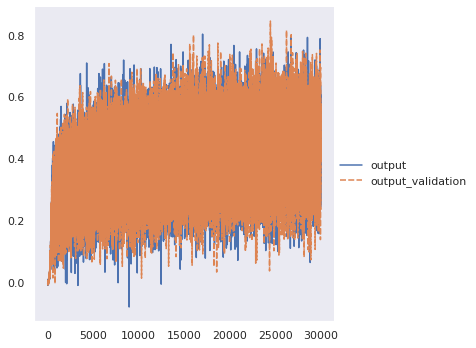

In [13]:
sns.relplot(data=df, kind='line')

Using an exponential moving average we can make the results look much better.
We use the formula $e_n = e_{n-1} + \alpha({data}_n - e_{n-1})$

In [14]:
def numpy_ewma(data, window):
    returnArray = np.empty((data.shape[0]))
    returnArray.fill(np.nan)
    e = data[0]
    alpha = 2 / float(window + 1)
    for s in range(data.shape[0]):
        e =  ((data[s]-e) *alpha ) + e
        returnArray[s] = e
    return returnArray

def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [15]:
df['output_ewma'] = numpy_ewma(df['output'], 2000)
df['output_validation_ewma'] = numpy_ewma(df['output_validation'], 2000)
df['x_axis'] = np.arange(len(result))

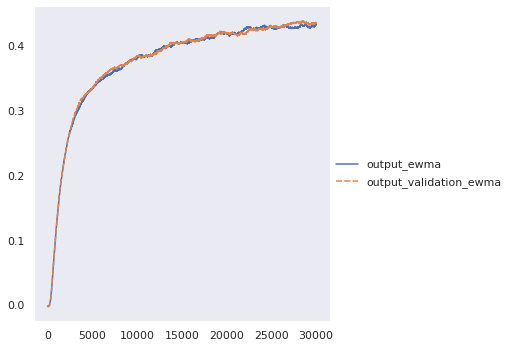

In [16]:
sns.relplot(data=df[['output_ewma', 'output_validation_ewma']], kind='line')

# Transfer learning

Let's see what happen if we try to use the same network already trained on a different temperature

In [17]:
ising_matrices = get_ising_matrices(1.9, directory)
ising_matrices = np.array(ising_matrices, dtype=np.float32)
ising_matrices -= 0.5
ising_matrices *= 2
ising_matrices = np.concatenate([ising_matrices, np.flip(ising_matrices, axis=1), np.flip(ising_matrices, axis=2)])
ising_subsystems = get_all_sub_matrices(ising_matrices, subsystem_shape, step=10)
train_data, test_data = train_test_split(ising_subsystems)

In [18]:
result_2, result_val_2 = train(train_data,mice_net,mice_net_optim, val_data=test_data, batch_size=192,
                       iter_num=int(1e+4))

MI for train 0.7078568935394287, val 0.6614373326301575 at step 1000 
MI for train 0.8525310754776001, val 0.752349317073822 at step 2000 
MI for train 0.8455016016960144, val 0.8078523874282837 at step 3000 
MI for train 0.7766408920288086, val 0.8313015103340149 at step 4000 
MI for train 0.7121773362159729, val 0.7826772928237915 at step 5000 
MI for train 0.7270019054412842, val 0.9169280529022217 at step 6000 
MI for train 0.732975423336029, val 0.7359781265258789 at step 7000 
MI for train 0.8286480903625488, val 0.7274349331855774 at step 8000 
MI for train 0.6873767971992493, val 0.7242211103439331 at step 9000 
MI for train 0.7298944592475891, val 0.8354246616363525 at step 10000 


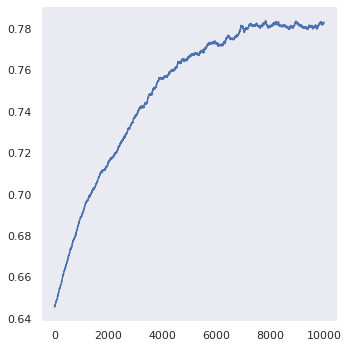

In [19]:
df = pd.DataFrame({'output': np.array(result_2), 'output_validation': np.array(result_val_2)})
df['output_ewma'] = numpy_ewma(df['output'], 2000)
df['output_validation_ewma'] = numpy_ewma(df['output_validation'], 2000)
df['x_axis'] = np.arange(len(result_2))
sns.relplot(data=df['output_ewma'], kind='line')

# Multiple temperatures

As we can see the network now reaches the plateau phase much faster, starting from a value of 0.7 already
We can repeat the process for many temperatures as follow

In [20]:
Ts = [round(T,2) for T in np.linspace(0.1, 4, 40)]
mi = np.zeros(len(Ts))

for idx,T in enumerate(Ts):
    print('Running on T {}'.format(T))
    ising_matrices = get_ising_matrices(T, directory)
    ising_matrices = np.array(ising_matrices, dtype=np.float32)
    ising_matrices -= 0.5
    ising_matrices *= 2
    ising_matrices = np.concatenate([ising_matrices, np.flip(ising_matrices, axis=1), np.flip(ising_matrices, axis=2)])
    ising_subsystems = get_all_sub_matrices(ising_matrices, subsystem_shape, step=10)
    train_data, test_data = train_test_split(ising_subsystems)
    result, result_val = train(train_data,mice_net,mice_net_optim, val_data=test_data, batch_size=192,
                       iter_num=int(3e+3))
    mi[idx] = numpy_ewma(np.array(result_val), 1000)[-1]

Running on T 0.1
MI for train 0.7242594957351685, val 0.6725268363952637 at step 1000 
MI for train 0.6947703957557678, val 0.6801983714103699 at step 2000 
MI for train 0.7545702457427979, val 0.7111790180206299 at step 3000 
Running on T 0.2
MI for train 0.6147463321685791, val 0.7922419309616089 at step 1000 
MI for train 0.8020434975624084, val 0.8140621781349182 at step 2000 
MI for train 0.6419298052787781, val 0.633459210395813 at step 3000 
Running on T 0.3
MI for train 0.780128538608551, val 0.6227448582649231 at step 1000 
MI for train 0.8266534805297852, val 0.7035937309265137 at step 2000 
MI for train 0.7801368236541748, val 0.575348436832428 at step 3000 
Running on T 0.4
MI for train 0.7035962343215942, val 0.7576625347137451 at step 1000 
MI for train 0.7466118931770325, val 0.850750744342804 at step 2000 
MI for train 0.682765543460846, val 0.6423582434654236 at step 3000 
Running on T 0.5
MI for train 0.7249690294265747, val 0.7141650915145874 at step 1000 
MI for tra

MI for train 0.5868449807167053, val 0.29356813430786133 at step 2000 
MI for train 0.44389277696609497, val 0.4168452024459839 at step 3000 
Running on T 3.8
MI for train 0.557115912437439, val 0.5785688757896423 at step 1000 
MI for train 0.4953981637954712, val 0.549732506275177 at step 2000 
MI for train 0.5860500335693359, val 0.5370914936065674 at step 3000 
Running on T 3.9
MI for train 0.5291689038276672, val 0.5911059379577637 at step 1000 
MI for train 0.5422639846801758, val 0.4633573293685913 at step 2000 
MI for train 0.44144895672798157, val 0.4146757125854492 at step 3000 
Running on T 4.0
MI for train 0.3780159652233124, val 0.35258767008781433 at step 1000 
MI for train 0.4095882773399353, val 0.474445104598999 at step 2000 
MI for train 0.36764007806777954, val 0.4016689658164978 at step 3000 


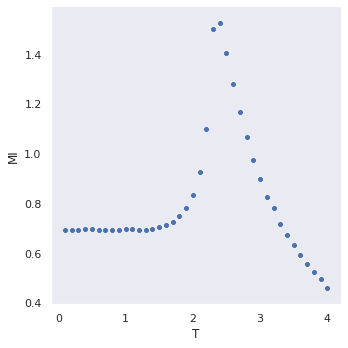

In [21]:
df = pd.DataFrame({'T': Ts, 'MI': mi})
sns.relplot(x='T', y='MI', data=df)